# Olist : clusterisation

In [161]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import davies_bouldin_score

In [162]:
data = pd.read_csv('data/olist_customers_whole.csv')

In [163]:
data.head()

,customer_unique_id,first_purchase,last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    96096 non-null  object 
 1   first_purchase        96096 non-null  object 
 2   last_purchase         96096 non-null  object 
 3   total_orders          96096 non-null  int64  
 4   total_spent           96095 non-null  float64
 5   average_review_score  279 non-null    float64
 6   all_comments          120 non-null    object 
 7   total_price_items     95420 non-null  float64
 8   total_freight_value   95420 non-null  float64
 9   product_categories    94107 non-null  object 
 10  seller_cities         95420 non-null  object 
 11  order_statuses        96096 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 8.8+ MB


In [165]:
data['average_review_score'].describe()

count    279.000000
mean       4.014337
std        1.429321
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: average_review_score, dtype: float64

In [166]:
#needs to translate last_purchase into datetime for later use
columns_to_translate_into_datetime = ['last_purchase', 'first_purchase']

data[columns_to_translate_into_datetime] = data[columns_to_translate_into_datetime].apply(pd.to_datetime)

In [167]:
#How many different product categories are there
pc = data['product_categories']
pc.nunique()

668

Product categories will probably not be usable, as there are so many of them

#### NAN identification and treatment

In [168]:
#Missing values exploration function
def null_table(df):
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values*100)/len(df)
    table = pd.concat([missing_values, missing_values_percent], axis=1)
    table_renamed = table.rename(
        columns = {0 : "Missing Values", 1  : "Percentage of total"})
    final_table = table_renamed[table_renamed.iloc[:,0] != 0].sort_values(
        by='Missing Values', ascending=False).round(2)
    
    return final_table

In [169]:
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_price_items,676,0.70
total_freight_value,676,0.70
seller_cities,676,0.70
total_spent,1,0.00


In [170]:
#filling function
def fill_with_median(data, column):
    median = data[column].median()
    data[column] = data[column].fillna(median)

    return data

In [171]:
# removing nan from the features we will use
data = fill_with_median(data, ['total_freight_value', 'total_price_items', 'total_spent'])

# checking for nan again
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
seller_cities,676,0.70


all_comments and average_review_score are over 99% empty, and therefore unusable for our analysis \
We will also drop seller cities, as these information concerns seller and not customers (should adjust SQL query accoringly)\
We will drop them before any other treatment

CAUTION ! These features could be very interesting, should they be better filled in the future ! \
Each instances of re-training should be accompanied by a new exploration regarding these features ! 

### A short review of outliers populations

#### Outliers detection

In [172]:
# with zscore
numerical_features = ['total_freight_value', 'total_price_items', 'total_spent']

for col in numerical_features:
    x = scp.stats.zscore(data[col], axis=None)
    y = x.where(x>abs(1.5)).value_counts().sum()
    outlier_percentage = round((y/len(x))*100, 2)
    print(col, y, 'outliers detected')
    print(outlier_percentage, '% of column')

total_freight_value 4088 outliers detected
4.25 % of column
total_price_items 3916 outliers detected
4.08 % of column
total_spent 1841 outliers detected
1.92 % of column


In [173]:
# with IQR
for col in numerical_features:
    
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
    total = outliers.value_counts().sum()
    outlier_percentage = round((total/len(data))*100, 2)
    
    print(col, total, 'outliers detected')
    print(outlier_percentage, '% of column')
    
    ''' # Visualize outliers using a box plot
    plt.boxplot(data[col], showfliers=True, sym='o')
    plt.title(f'Box Plot of {col}')
    plt.xlabel('Feature')
    plt.ylabel(col)
    plt.show()'''

total_freight_value 9283 outliers detected
9.66 % of column
total_price_items 8147 outliers detected
8.48 % of column
total_spent 9441 outliers detected
9.82 % of column


IQR method seems more severe. Due to the lack of data, we will try to increase its quality by applying sever corrections 

#### Outliers treatment

Since more than 5% of columns are outliers, we will try either to replace outliers with median or perhaps an IterativeImputer, if correlated pairs are identified

In [174]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def iterative_filling(df, threshold):
    #identify NUMERCIAL values
    numerical_to_fill = df.select_dtypes(np.number)
    #analyze correlation
    corrmap = numerical_to_fill.corr()
    #defining threshold
    mask = np.abs(corrmap) > threshold
    #preparing the pairs
    correlated_pairs = []
    # Iterate over the correlation matrix
    for i in range(len(corrmap.columns)):
        for j in range(i+1, len(corrmap.columns)):  # Start from i+1 to avoid self-comparison
            if np.abs(corrmap.iloc[i, j]) > threshold:
                # Append the pair of feature names if above threshold
                correlated_pairs.append([corrmap.columns[i], corrmap.columns[j]])
    
    #initialize iterative imputer
    iter_imputer = IterativeImputer(max_iter=10, random_state=42)

    #imputing pair by pair
    for pair in correlated_pairs:
        # Select only the columns in the pair for imputation
        df_pair = df[pair]
        # Apply imputation
        df_imputed = iter_imputer.fit_transform(df_pair)
        # Update the original DataFrame with the imputed values
        df[pair] = df_imputed
    
    return df

In [207]:
#first turn outliers into nans

for col in numerical_features:
    
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data.loc[(data[col] < lower_bound) | (data[col] > upper_bound), col] = np.nan

#then fill nans with function
data = iterative_filling(data, 0.80)

#### Visual representation

<function matplotlib.pyplot.show(close=None, block=None)>

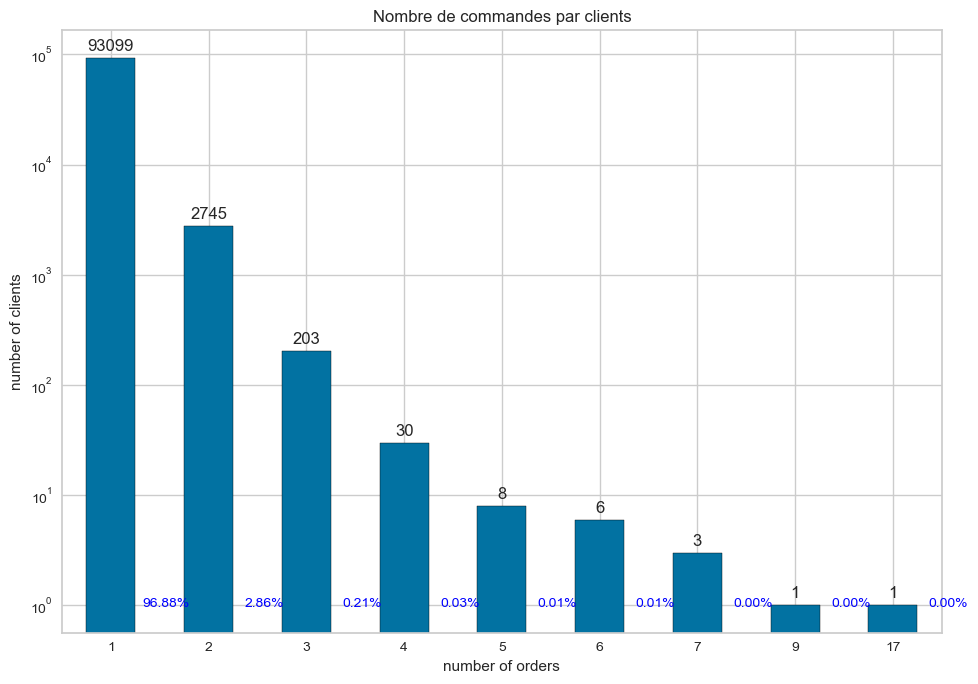

In [176]:
#plotting the number of orders by clients
fig = plt.figure(figsize=(10, 7))
x = data['total_orders'].value_counts().sort_index()
total = x.sum()
ax = x.plot(kind='bar', edgecolor='black')

for xaxis, yaxis in enumerate(x):
    ax.annotate(str(yaxis), xy=(xaxis, yaxis),  xytext=(0, 5), textcoords='offset points', ha='center')

for xaxis, yaxis in enumerate(x):
    percentage = (yaxis / total) * 100
    ax.annotate(f'{percentage:.2f}%', xy=(xaxis, 1),  xytext=(40, 5), textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')

plt.yscale('log')
plt.xlabel('number of orders')
plt.xticks(rotation=0)
plt.ylabel('number of clients')
plt.title('Nombre de commandes par clients')
plt.tight_layout()

plt.show

piechart : 1 commande VS les autres

On constate qu'à peine plus que 3% des clients on fait plus qu'une seule commande

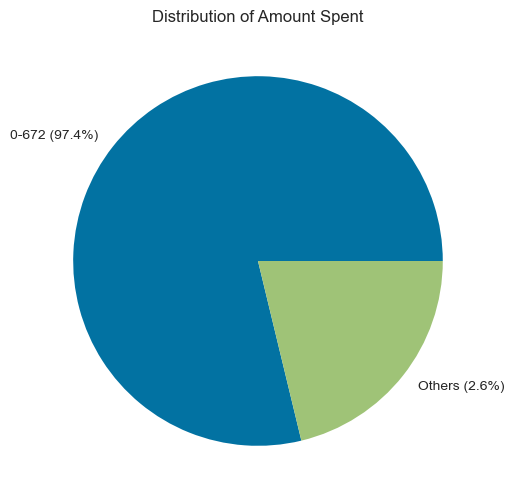

In [177]:
# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=20)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Calculate the percentage of people in each bin
total_people = len(data)
percent_people = [(data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].count() / total_people) * 100 for i in range(len(bins)-1)]

# Create labels for the pie chart
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])} ({percent_people[i]:.1f}%)' for i in range(len(bins)-1)]

# Group the bins with small percentages into an 'Others' category
threshold = 5  # percentage

# Initialize lists for the new labels and totals
new_bin_totals = []
new_bin_labels = []

# Track totals for 'Others' category
others_total = 0
others_percentage = 0

# Iterate through the bins and group small percentages
for total, label, percentage in zip(bin_totals, bin_labels, percent_people):
    if percentage >= threshold:
        new_bin_totals.append(total)
        new_bin_labels.append(label)
    else:
        others_total += total
        others_percentage += percentage

# Add the 'Others' category if needed
if others_total > 0:
    new_bin_totals.append(others_total)
    new_bin_labels.append(f'Others ({others_percentage:.1f}%)')

# Create the pie chart with the new bins
plt.figure(figsize=(10, 6))
plt.pie(new_bin_totals, labels=new_bin_labels, startangle=0)
plt.title('Distribution of Amount Spent')
plt.show()

97.4% des clients ont un panier moyen de 120 Reals

### RFM : Récence Fréquence Montant

In [178]:
#Recence

#calculate the time since last seen
current_date = pd.to_datetime(datetime.now().date()) #maybe not use the current date but last date of DB update ('2021-10-01')
data['days_since_last_purchase'] = (current_date - data['last_purchase']).dt.days

# Insert the new column after the last_seen column
last_purchase_index = data.columns.get_loc('last_purchase')
data.insert(last_purchase_index + 1, 'days_since_last_purchase', data.pop('days_since_last_purchase'))

data.head()

,customer_unique_id,first_purchase,last_purchase,days_since_last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,2129,17,630.693567,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,2303,9,849.121679,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,2182,7,578.009251,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,2209,7,692.695486,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,2316,7,731.834247,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


Features RFM retenues : 
- last_purchase = Récence
- days_since_last_purchase = Fréquence
- total_price_items = Montant

In [179]:
#New df with only the 3 needed features
#Use the customer unique id as index ? 
columns_RFM = ['last_purchase', 'days_since_last_purchase', 'total_price_items']
data_RFM = data[columns_RFM]

data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,2018-08-20 19:14:26,2129,729.62
1,2018-02-27 18:36:39,2303,1000.85
2,2018-06-28 00:43:34,2182,664.20
3,2018-06-01 11:38:29,2209,806.61
4,2018-02-14 13:22:12,2316,855.21
...,...,...,...
96091,2018-06-06 10:46:09,2204,223.00
96092,2017-12-17 23:31:33,2375,59.00
96093,2017-08-04 23:18:15,2510,143.80
96094,2018-08-12 20:27:59,2137,30.00


#### Moving on : standardscaling

In [180]:
#Can't standardscale the datetime column
data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())

C:\Users\kanam\AppData\Local\Temp\ipykernel_15112\1263757375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())


In [181]:
#BTW let's check again for nans
null_table(data_RFM)

,Missing Values,Percentage of total


In [182]:
#filling the blanks again
for col in data_RFM.columns:
    median = data[col].median()
    data[col] = data[col].fillna(median)

null_table(data_RFM)

,Missing Values,Percentage of total


In [183]:
data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,1.534792e+09,2129,729.62
1,1.519757e+09,2303,1000.85
2,1.530147e+09,2182,664.20
3,1.527853e+09,2209,806.61
4,1.518615e+09,2316,855.21
...,...,...,...
96091,1.528282e+09,2204,223.00
96092,1.513553e+09,2375,59.00
96093,1.501889e+09,2510,143.80
96094,1.534106e+09,2137,30.00


In [184]:
#Stand-alone scaling for graphs
scaler = StandardScaler()
data_RFM_scaled = scaler.fit_transform(data_RFM)

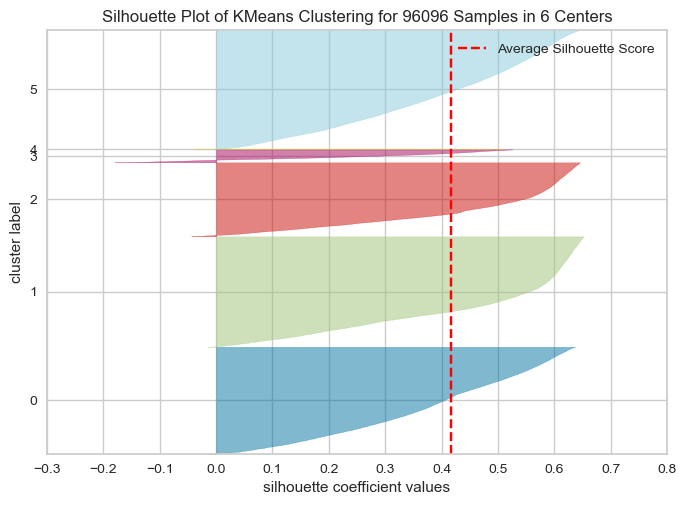

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96096 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [185]:
#density visualizer Silhouette on 6 clusters
model = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show() 

silhouette is way longer than Elbow

model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', k=(4,12))

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show()

distortion score + davis bouldin + score silhouette sur le meme graph \
pipeline = standardscaler + reentrainement kmeans final

In [186]:
#Pipeline scaling+training
def train_kmeans(data, scaler, best_k):
    pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])
    return pipeline.fit(data)

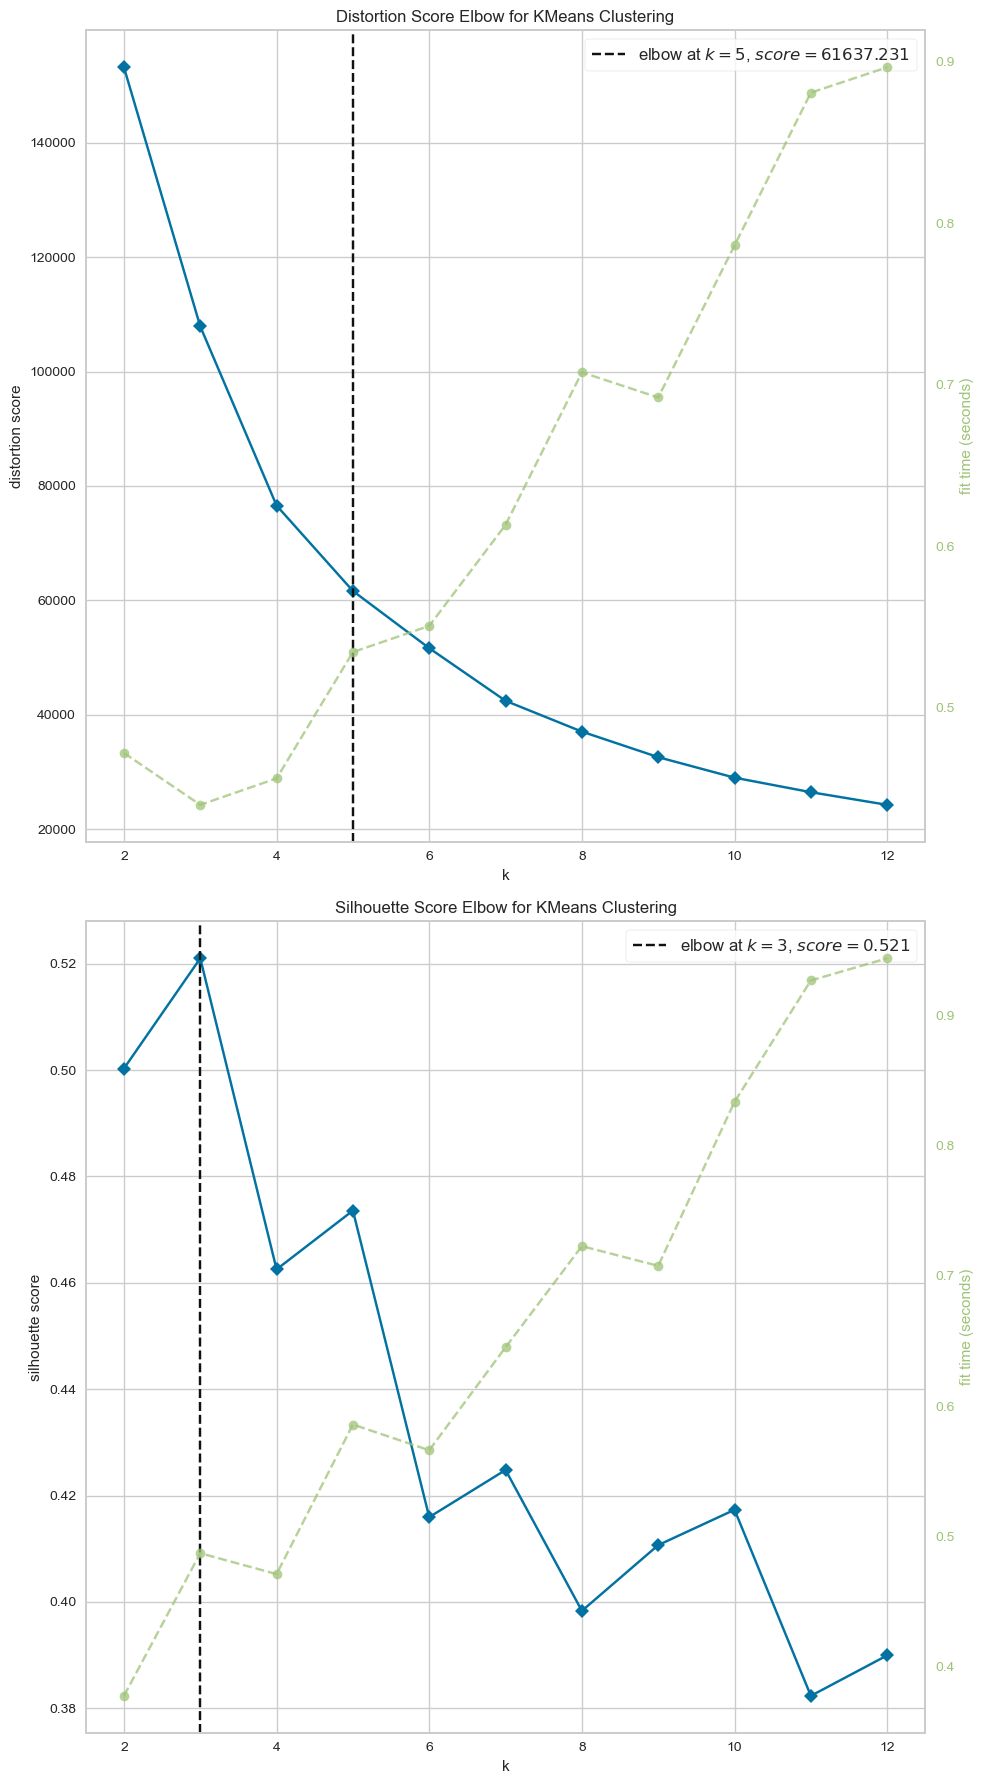

In [187]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 18))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_scaled)
elbow_visualizer.finalize()

# Silhouette Score
km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

Optimal K confirmed between 4 and 2 ? 3 et 5 ? probably 4

Using the total number of clients is not necessarily relevant, due to the only one purchase made bringing very little information

Using only the multiple times buyer :
pros = better information
cons = 97% of data is unusable (only 3000 customers)

Not reasonnably feasable, but worth to mention to olist teams

Adding features : 

- total_orders => indicates if customers returns to olist, and how much so.
- I don't like the all_comments and review_score features, as they are very limited (120 and 279 non-null only)
- total_freight_value => is the client ready to spend with olist despite the distance and increased freigth tarification

Rework the SQL query to include more features ?

récupérer le label attribué avec .labels_
merge avec le dataframe
ensuite groupby cluster pour les analyses
analyse bivariés => corrélation (pearson)

boxplots : feature par cluster ET cluster par features

diagramme RADAR feature par cluster

Enrichir le jeu de données => total_orders / total_freight_value

A tester 
DBSCAN => répartition étrange des clusters => trop peu de données pertinentes
CAH => difficile à faire tourner => n'utiliser que 5% du dataset => Très puissant mais trop gourmand

+ review et correction de code

In [188]:
#pipeline.fit(data_RFM_scaled)
#Using pipeline to train kmeans
km = train_kmeans(data_RFM, StandardScaler(), 4)
km_clusters = km.predict(data_RFM)
km_clusters
# Does the predict method need to be used on scaled data ? Or can it be used on unscaled data
data_RFM['km_cluster'] = km_clusters

C:\Users\kanam\AppData\Local\Temp\ipykernel_15112\780316972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['km_cluster'] = km_clusters


In [189]:
data_RFM.head()

,last_purchase,days_since_last_purchase,total_price_items,km_cluster
0,1.534792e+09,2129,729.62,0
1,1.519757e+09,2303,1000.85,3
2,1.530147e+09,2182,664.20,0
3,1.527853e+09,2209,806.61,0
4,1.518615e+09,2316,855.21,3


#### Analyse par cluster

In [190]:
data_cluster = data_RFM.groupby('km_cluster')
cluster_repartition = (data_cluster['km_cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

km_cluster
0    37.805944
1    23.113345
2    37.440684
3     1.640027
Name: count, dtype: float64

On note une grande irrégularité, un des cluster est très peu peuplé

#### Feature by cluster

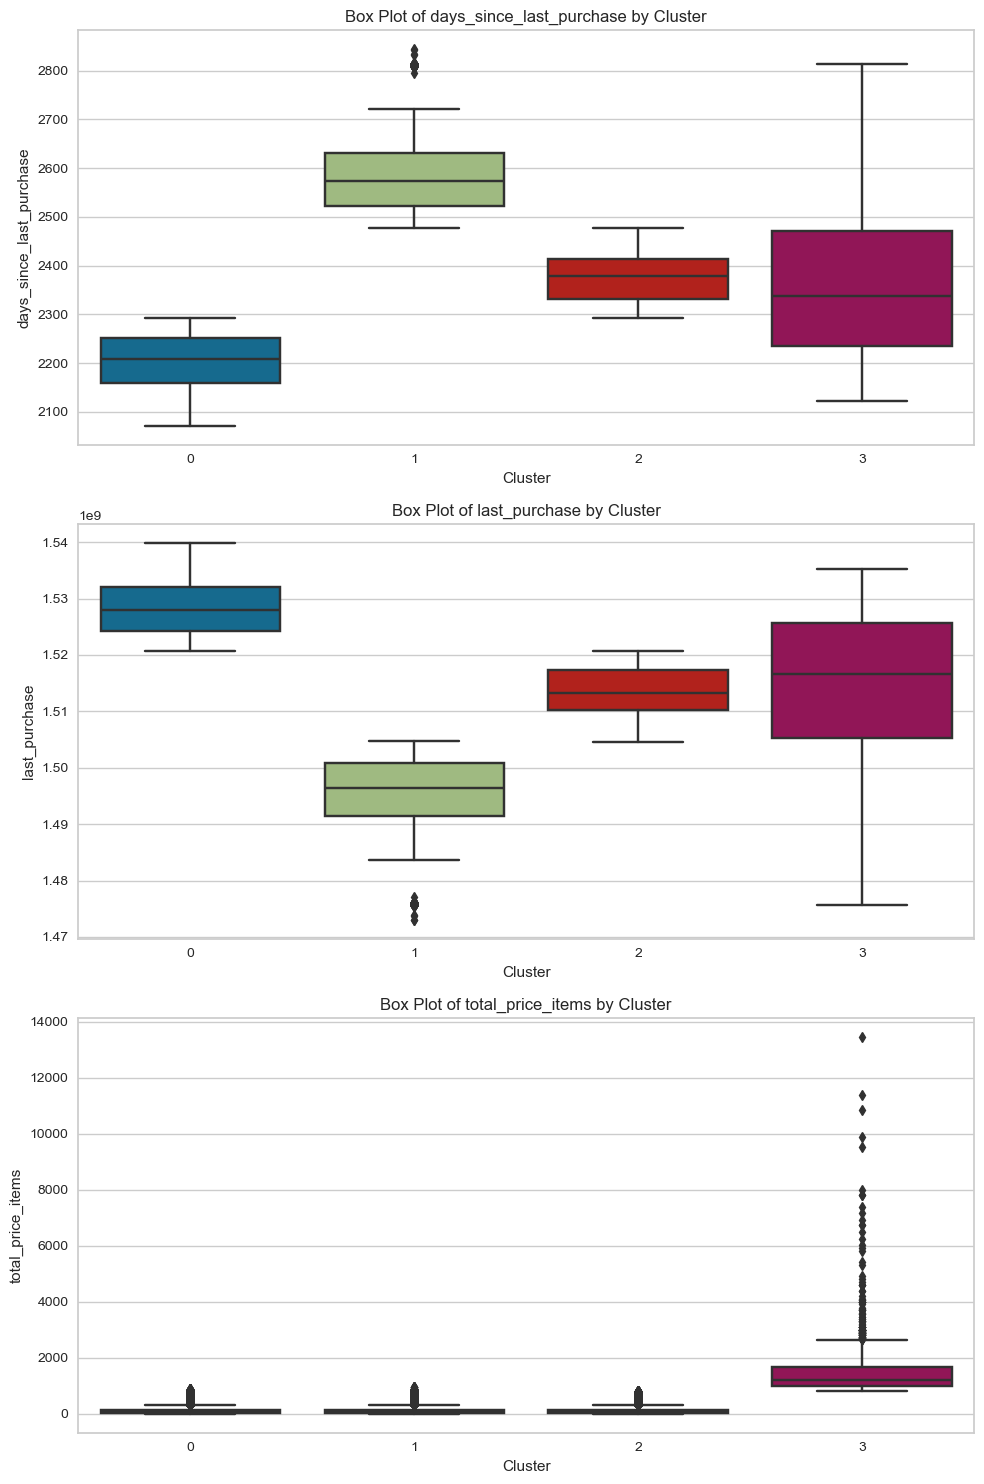

In [191]:
features = data_RFM.columns.difference(['km_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='km_cluster', y=feature, data=data_RFM, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

Looks like the total_price_items needs some more cleaning

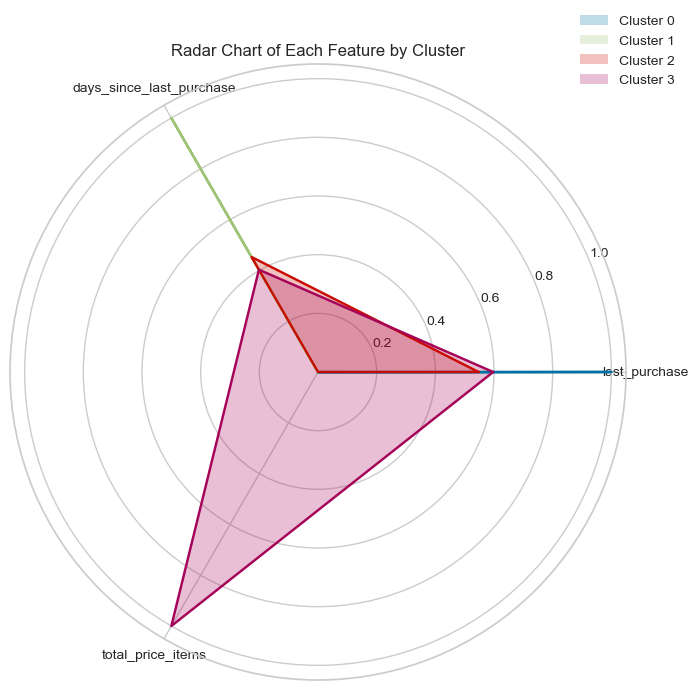

In [192]:
#RADAR
# Calculate the mean of each feature for each cluster
cluster_means = data_RFM.groupby('km_cluster').mean()

# Normalize the feature values
scaler = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means), columns=cluster_means.columns)

# Number of clusters and features
num_clusters = cluster_means_normalized.shape[0]
num_features = cluster_means_normalized.shape[1]

# Create radar chart
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for i in range(num_clusters):
    values = cluster_means_normalized.iloc[i].tolist()
    values += values[:1]  # Complete the loop
    ax.fill(angles, values, alpha=0.25, label=f'Cluster {i}')
    ax.plot(angles, values)

# Add feature labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_means.columns)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display the radar chart
plt.title('Radar Chart of Each Feature by Cluster')
plt.show()

#### Cluster by feature

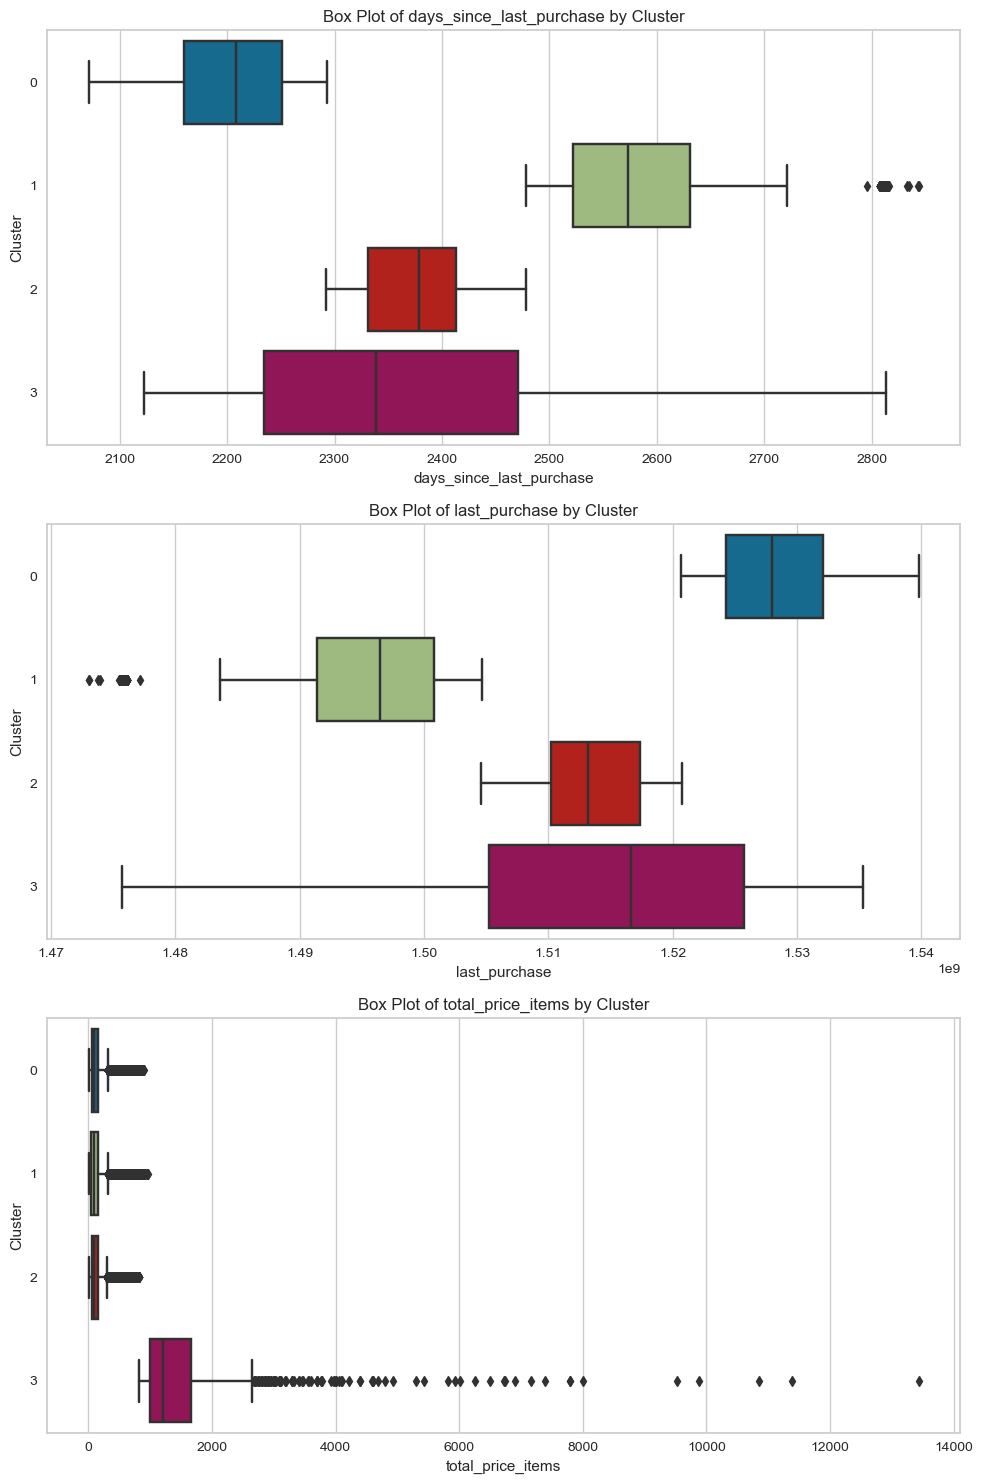

In [193]:
# Get the list of features (excluding the 'cluster' column)
features = data_RFM.columns.difference(['km_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(y='km_cluster', x=feature, data=data_RFM, ax=ax, orient='h')
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

isn't it the same as the previous one ? 

#### Enrich the dataset

In [194]:
#joining two new columns
data_RFM_enriched = data_RFM.join(data['total_freight_value'], how='left')
data_RFM_enriched = data_RFM_enriched.join(data['total_orders'], how='left')

data_RFM_enriched.head()

,last_purchase,days_since_last_purchase,total_price_items,km_cluster,total_freight_value,total_orders
0,1.534792e+09,2129,729.62,0,172.42,17
1,1.519757e+09,2303,1000.85,3,171.82,9
2,1.530147e+09,2182,664.20,0,94.63,7
3,1.527853e+09,2209,806.61,0,316.11,7
4,1.518615e+09,2316,855.21,3,165.91,7


### Fit a new kmeans with new columns

#### New exploration

In [208]:
#drop the cluster to new clusterization
data_RFM_enriched = data_RFM_enriched.drop(columns='km_cluster')
display(data_RFM_enriched.head())

'''#is there NaN ? 
null_table(data_RFM_enriched)'''

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,km_enriched_cluster,DBSCAN_cluster
0,1.534792e+09,2129,729.62,172.42,17,4,-1
1,1.519757e+09,2303,1000.85,171.82,9,4,-1
2,1.530147e+09,2182,664.20,94.63,7,4,-1
3,1.527853e+09,2209,806.61,316.11,7,4,-1
4,1.518615e+09,2316,855.21,165.91,7,4,-1


'#is there NaN ? \nnull_table(data_RFM_enriched)'

In [196]:
#filling NAs
for col in data_RFM_enriched.columns:
    data_RFM_enriched=data_RFM_enriched.fillna(data_RFM_enriched[col].median())
#checking
null_table(data_RFM_enriched)

,Missing Values,Percentage of total


In [209]:
#StandardScale for graphs
scaler = StandardScaler()
data_RFM_enriched_scaled = scaler.fit_transform(data_RFM_enriched)

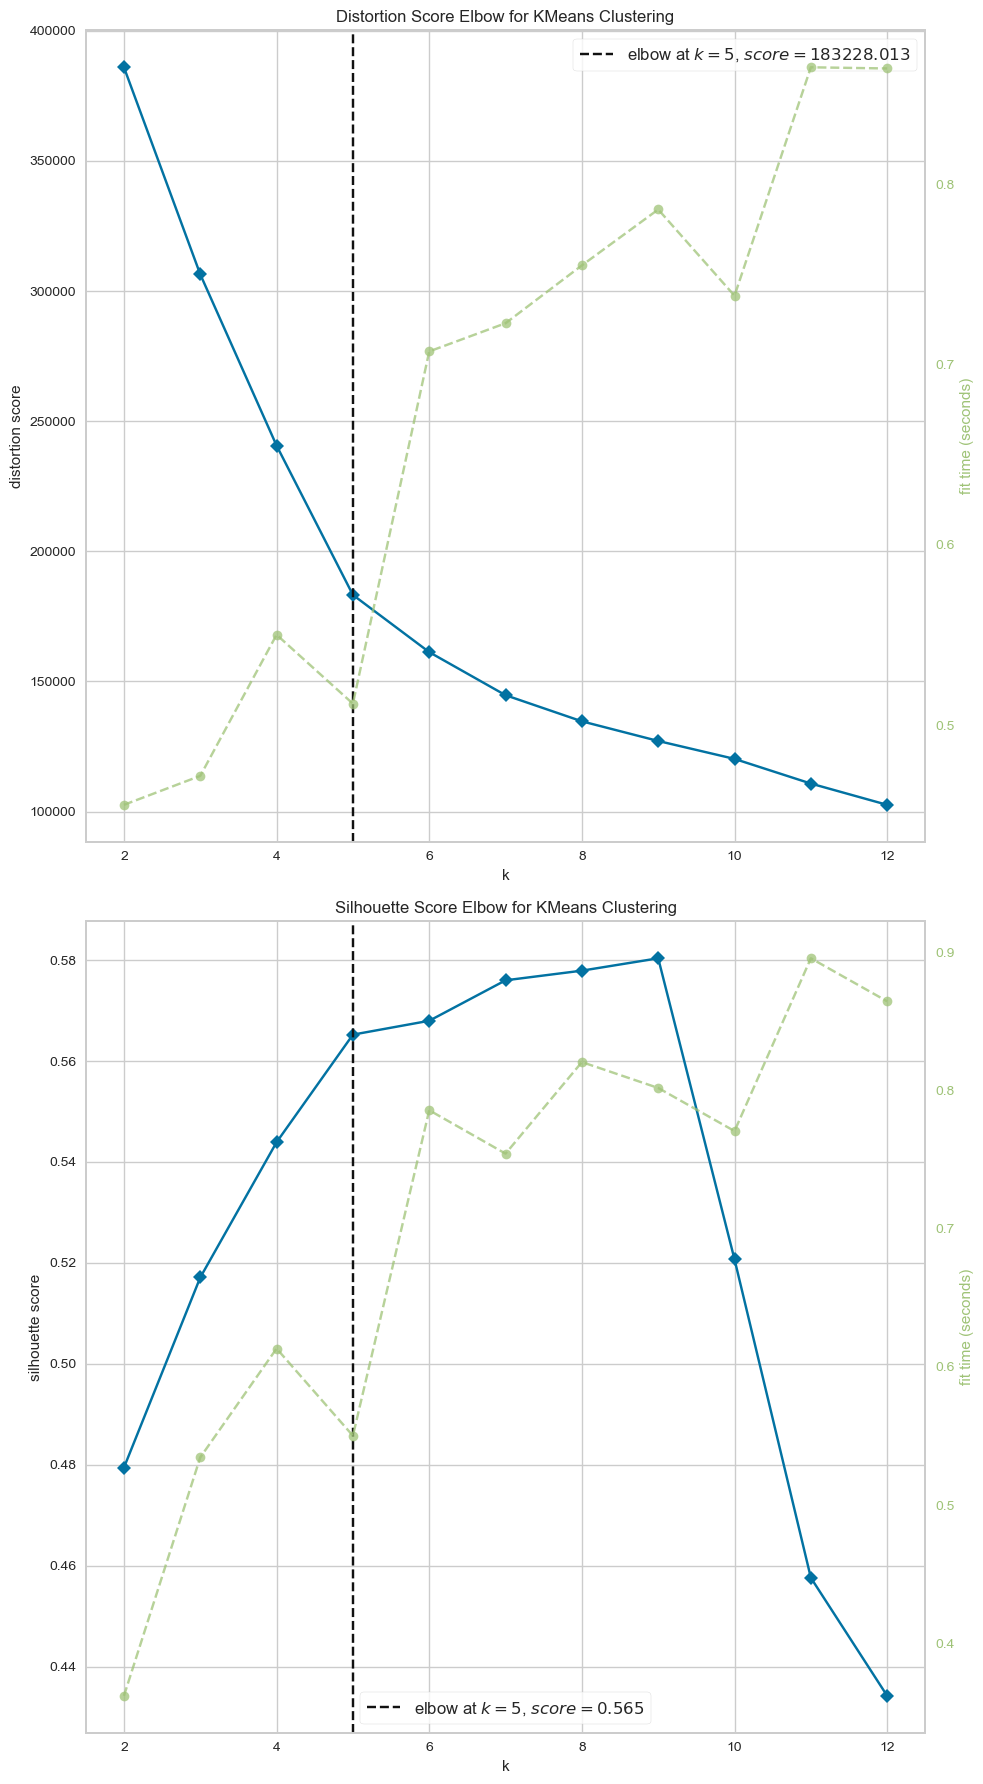

In [198]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 18))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_enriched_scaled)
elbow_visualizer.finalize()

# Silhouette Score
#km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_enriched_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

best k is 5 

In [199]:
km_enriched = train_kmeans(data_RFM_enriched, StandardScaler(), 5)

data_RFM_enriched['km_enriched_cluster'] = km_enriched.predict(data_RFM_enriched)
data_RFM_enriched

,last_purchase,days_since_last_purchase,total_price_items,km_cluster,total_freight_value,total_orders,km_enriched_cluster
0,1.534792e+09,2129,729.62,0,172.42,17,4
1,1.519757e+09,2303,1000.85,3,171.82,9,4
2,1.530147e+09,2182,664.20,0,94.63,7,4
3,1.527853e+09,2209,806.61,0,316.11,7,4
4,1.518615e+09,2316,855.21,3,165.91,7,4
...,...,...,...,...,...,...,...
96091,1.528282e+09,2204,223.00,0,19.44,1,1
96092,1.513553e+09,2375,59.00,2,17.66,1,0
96093,1.501889e+09,2510,143.80,1,18.90,1,3
96094,1.534106e+09,2137,30.00,0,8.37,1,1


In [200]:
data_cluster = data_RFM_enriched.groupby('km_enriched_cluster')
cluster_repartition = (data_cluster['km_enriched_cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

km_enriched_cluster
0    36.293914
1    36.417749
2     1.776349
3    22.455669
4     3.056319
Name: count, dtype: float64

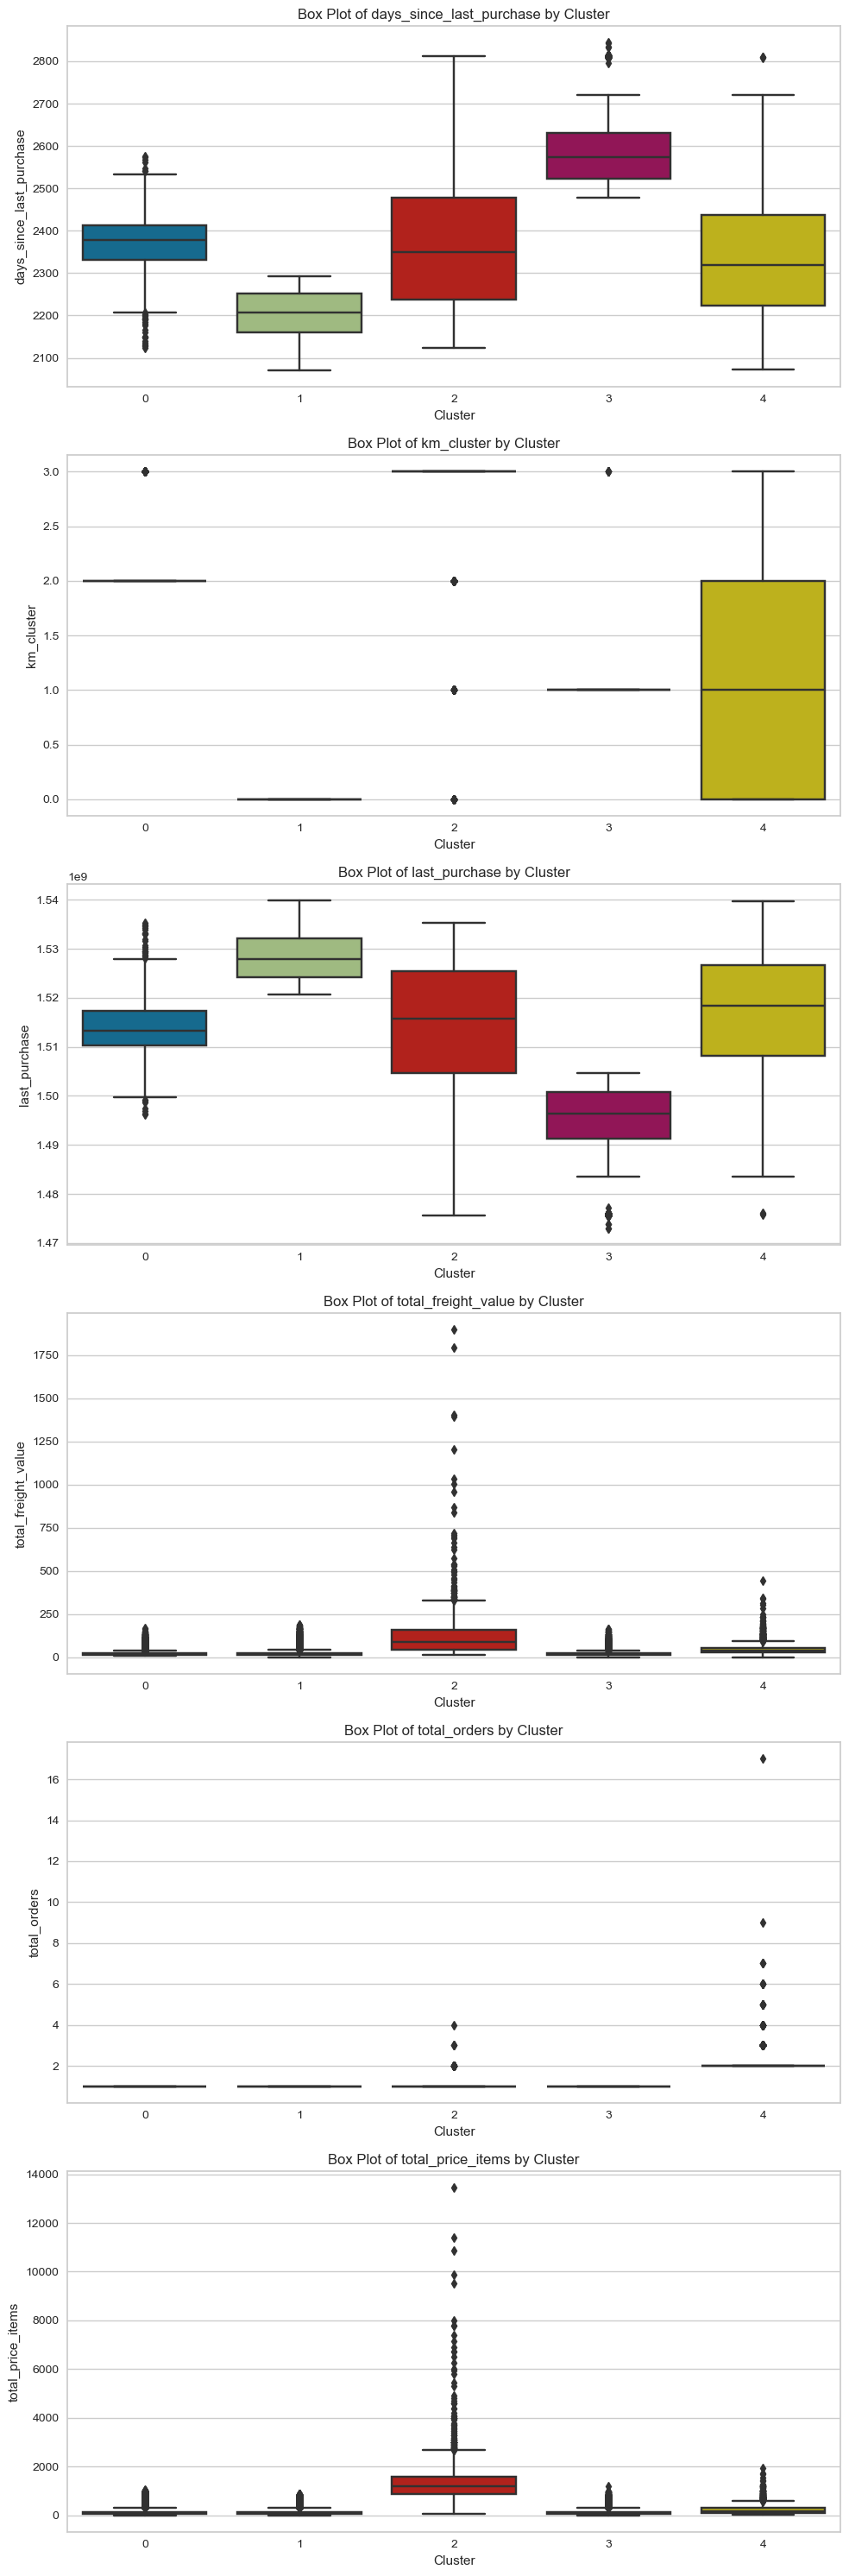

In [201]:
features = data_RFM_enriched.columns.difference(['km_enriched_cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='km_enriched_cluster', y=feature, data=data_RFM_enriched, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

It seems that two clusters have very little population

Also, could it be interesting to map the correlation between the two clustering and see if its well worrelated or not ?

#### DBSCAN approach

In [202]:
clustering = DBSCAN().fit(data_RFM_enriched_scaled)

clusterized = clustering.labels_
data_RFM_enriched['DBSCAN_cluster'] = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusterized)) - (1 if -1 in clusterized else 0)
n_noise_ = list(clusterized).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 37
Estimated number of noise points: 1052


24 clusters is far from the first estimation obtained with silhouette score and Elbow method

In [203]:
data_cluster = data_RFM_enriched.groupby('DBSCAN_cluster')
DB_cluster_repartition = (data_cluster['DBSCAN_cluster'].value_counts() / len(data_RFM_enriched))*100
DB_cluster_repartition

DBSCAN_cluster
-1      1.094739
 0      0.052031
 1      0.006244
 2      0.006244
 3      0.006244
 4      0.017691
 5      1.072885
 6      1.043748
 7      0.485972
 8      0.010406
 9      0.005203
 10    36.477065
 11    22.134116
 12    36.214827
 13     0.296578
 14     0.916792
 15     0.008325
 16     0.009366
 17     0.012488
 18     0.008325
 19     0.008325
 20     0.010406
 21     0.006244
 22     0.009366
 23     0.011447
 24     0.005203
 25     0.005203
 26     0.009366
 27     0.004163
 28     0.007284
 29     0.004163
 30     0.006244
 31     0.004163
 32     0.006244
 33     0.005203
 34     0.008325
 35     0.004163
 36     0.005203
Name: count, dtype: float64

Only 6 clusters have 1% or more of the data, which is more coherent with the previously obtained estimations

The main problem is that DBSCAN is a density algorithm. Our data only contains 3000 clients with more than 1 purchase, but the clustering is made on all the dataset

#### HAC approach

Maybe include customer_unique_id ? Or scale the whole data and stop using a scaled version and unscaled version

In [205]:
#made with AgglomerativeClustering AND sampling first 

sampled_data_RFM_enriched = data_RFM_enriched.sample(frac=0.05, random_state=42)
sampled_data_RFM_enriched = sampled_data_RFM_enriched.drop(columns=['DBSCAN_cluster'])
sampled_data_RFM_enriched_scaled = scaler.fit_transform(sampled_data_RFM_enriched)

HAC_clustering = AgglomerativeClustering().fit(sampled_data_RFM_enriched_scaled)

HAC_clustering.labels_
sampled_data_RFM_enriched['HAC_cluster'] = HAC_clustering.labels_

data_cluster = sampled_data_RFM_enriched.groupby('HAC_cluster')
DB_cluster_repartition = (data_cluster['HAC_cluster'].value_counts() / len(sampled_data_RFM_enriched))*100
DB_cluster_repartition

#running time : 

HAC_cluster
0    40.145682
1    59.854318
Name: count, dtype: float64

### Algorithm choice

Kmeans : 
 - Can be checked with silhouette and Elbow
 - Quick enough
 - Easily adjustable


DBSCAN : 
 - Harder to check
 - Fairly quick
 - harder to adjust

HAC : 
 - Infernally long
 - Difficult to adjust


We can see that the kmeans algorithm is better, faster, and more coherent regarding the data
We will therefore move on with this algorithm, with a clustering of 5

#### Cluster explanation : domain-wise

How to explain each cluster domain-wise


Relying on the boxplot made by cluster :
First clustering
 - Cluster 0 = last purchase
 - Cluster 1 = day since last purchase
 - Cluster 2 = 1%
 - Cluster 3 = total price items

Second clustering
 - 

### Export final dataset and model

In [206]:
data_RFM_enriched.to_csv('data/data_with_clustering.csv', index = False)

# Save the model
kmeans_final = train_kmeans(data_RFM_enriched, StandardScaler(), 4)
joblib_file = "kmeans_model.pkl"
joblib.dump(kmeans_final, joblib_file)

['kmeans_model.pkl']